In [688]:
import numpy as np
import pandas as pd
import pandas.io.date_converters as conv
import matplotlib.pyplot as plt
import seaborn as sns
import glob #used for reading multiple csvs
import geoplot as gplt
import geopandas as gpd
import geoplot.crs as gcrs
import mapclassify

### COVID-19 CHINA

In [683]:
path = "./data/COVID-19-master/archived_data/archived_daily_case_updates"
all_covid_files = glob.glob(path + "/0*.csv")
covid = pd.DataFrame()
for filename in all_covid_files:
    df= pd.read_csv(filename)
    covid = covid.append(df)

In [684]:
covid = covid.rename(columns = {"Last Update":"time"})
covid.time = covid["time"].apply(lambda x: pd.to_datetime(x.split("/")[0]+"/"+x.split("/")[1]+"/2020", format='%m/%d/%Y') if x[1]=='/' else  pd.to_datetime(x[:10], format='%Y/%m/%d'))
covid.time = pd.to_datetime(covid.time,infer_datetime_format=True)
covid.reset_index(inplace=True,drop=True)
covid = covid.groupby(['time','Country/Region','Province/State'],as_index = False).max()

In [685]:
covid.head()

time  Country/Region Province/State  Confirmed  ConfnSusp  Deaths  \
0 2020-01-21       Hong Kong      Hong Kong        NaN        NaN     NaN   
1 2020-01-21  Mainland China          Anhui        NaN        NaN     NaN   
2 2020-01-21  Mainland China        Beijing       10.0        NaN     NaN   
3 2020-01-21  Mainland China      Chongqing        5.0        NaN     NaN   
4 2020-01-21  Mainland China      Guangdong       17.0        NaN     NaN   

   Recovered  Suspected  
0        NaN      117.0  
1        NaN        3.0  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        4.0

In [304]:
covid_china=covid[covid["Country/Region"]=="Mainland China"]
chn_provs = list(covid_china["Province/State"].unique())

In [341]:
def plot_covid(frame,provs =chn_provs, column='Confirmed',nrows=5,ncols=7,fsize = (25,18),title=None):
    if title is None:
        title =column
    plt.figure(figsize=fsize)
    for i in range(len(provs)):
        row = i//ncols
        col = i-row*ncols
        ax = plt.subplot2grid((nrows,ncols), (row,col))
        df = frame[frame["Province/State"]==provs[i]]
        ax.plot(df["time"],df[column])
        # Only label every 20th value
        ticks_to_use = df.time.iloc[range(0,len(df.time),10)]

        # Set format of labels (note year not excluded as requested)
        labels = [ i.strftime("%m%d") for i in ticks_to_use ]

        # Now set the ticks and labels
        ax.set_xticks(ticks_to_use)
        ax.set_xticklabels(labels)
        ax.set_title(provs[i])
    plt.suptitle(title,fontsize=20)

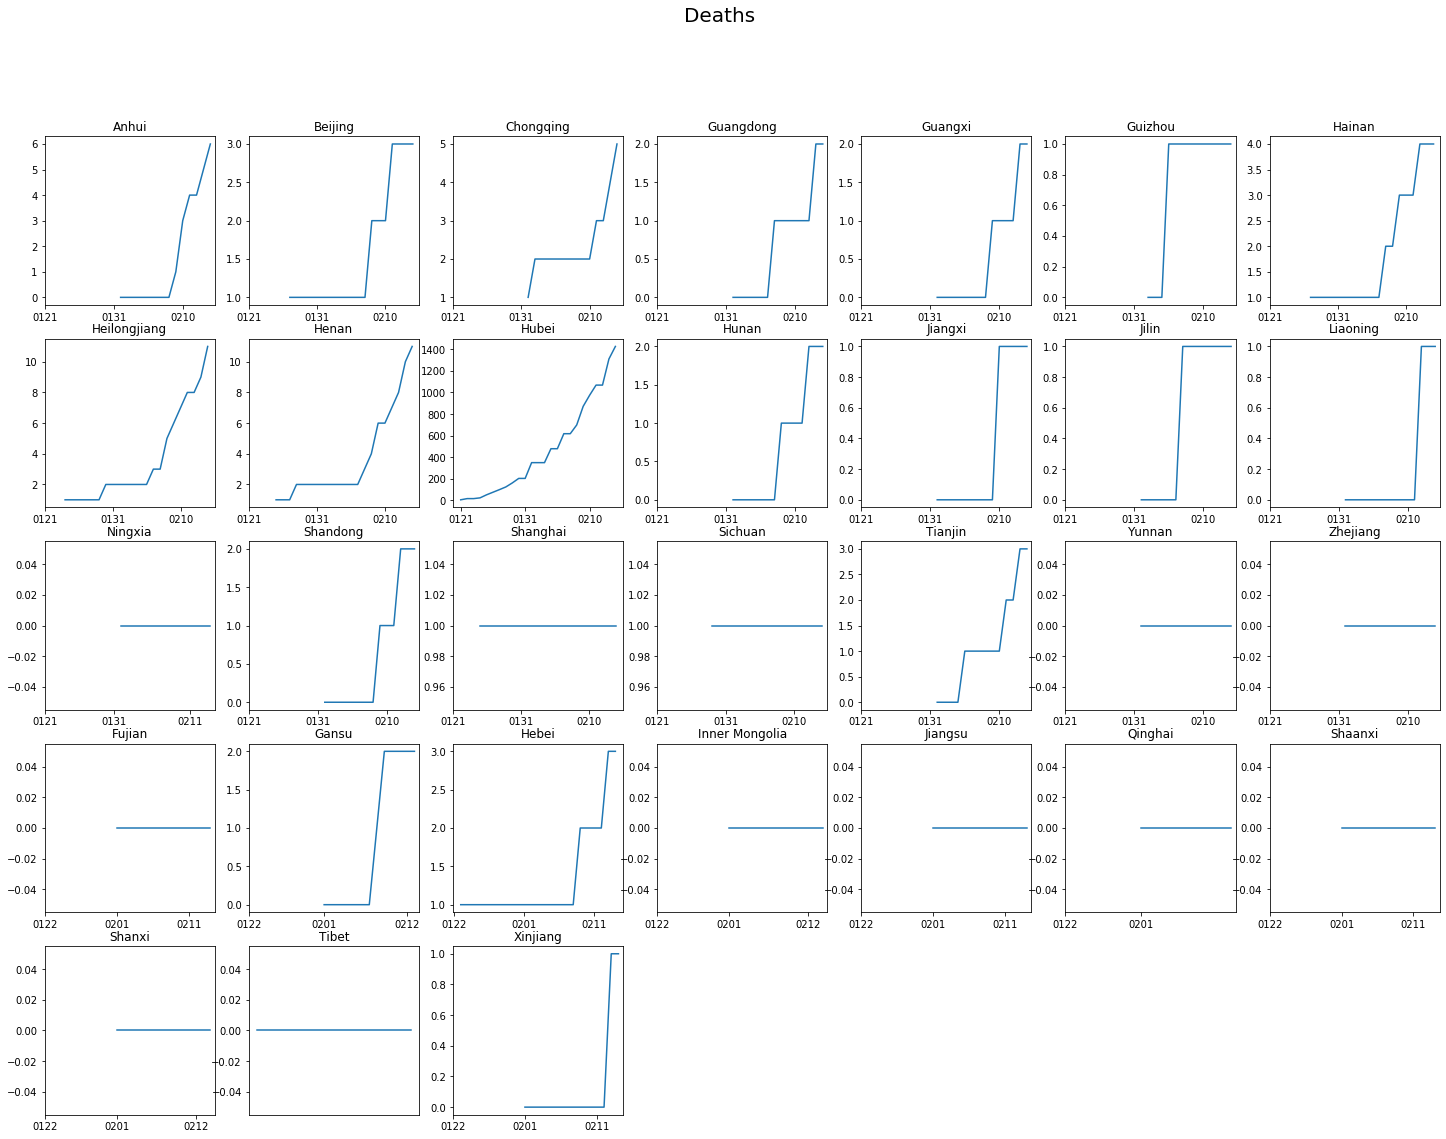

In [310]:
plot_covid(covid_china,chn_provs,'Deaths')

In [313]:
plot_covid(covid_china,chn_provs,'Confirmed')

### COVID-19 US

In [732]:
path = "./data/COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports"
all_covid_files = glob.glob(path + "/*.csv")
covid_dr = pd.DataFrame()
for filename in all_covid_files:
    date = (filename.split("\\")[-1]).split(".")[0]    
#     print(date)
    df= pd.read_csv(filename)
    df["time"] = date
#     df.time = pd.to_datetime(df.time,infer_datetime_format=True)
    covid_dr = covid_dr.append(df)
covid_dr = covid_dr.drop(["Last Update"],axis=1)
covid_dr = covid_dr.groupby(['time','Combined_Key'],as_index = False).max()

In [667]:
usa_cities = gpd.read_file(gplt.datasets.get_path('usa_cities'))
usa_cities.head()
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

In [690]:
us = geopandas.read_file("D:/Harvard_course/cs109/final/data/US_County_Boundaries.shp")

In [722]:
covid_dr = covid_dr.fillna(0)
covid_dr["FIPS"]=list(map(lambda x: str(int(x)),covid_dr["FIPS"]))
covid_state = covid_dr[covid_dr["Country_Region"]=="US"]

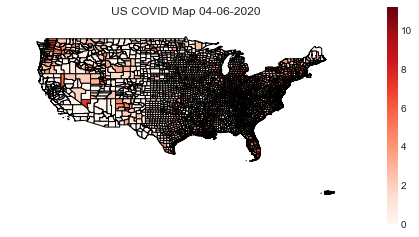

In [731]:
def infect_plot_us(date="04-06-2020"):
    covid_county = covid_state[covid_state.time==date]
    covid_county   = covid_county.fillna(1)
    covid_county.loc[covid_county.Confirmed==0,"Confirmed"] =1
    #     print(sum(covid_t.Confirmed<0))
#     us1 = contiguous_usa.merge(covid_county,left_on="state",right_on ="Province_State", how='left')
    us1 = us.merge(covid_county,left_on="CTFIPS",right_on ="FIPS", how='left')
    us1 = us1[us1.STATE!="Hawaii"]
    us1 = us1[us1.STATE!="Alaska"]
    gpd_per_person =np.log(us1['Confirmed'])
    scheme = mapclassify.Quantiles(gpd_per_person, k=10)

    # Note: this code sample requires geoplot>=0.4.0.
    gplt.choropleth(
        us1, hue=gpd_per_person,
        cmap='Reds', figsize=(8, 4),legend=True
    )
    plt.title("US COVID Map "+date)
infect_plot_us()

### WHO data

The WHO has recorded the number of confirmed cases every day in every member country/region. If we combine the data with country-specific features, such as populetion density, social manner, climate and social infrastructure, we might see which factors would influence the development of the pandemic.

In [545]:
path = "./data/COVID-19-master/who_covid_19_situation_reports/who_covid_19_sit_rep_time_series/who_covid_19_sit_rep_time_series.csv"
covid_who= pd.read_csv(path,keep_default_na='0')
covid_c = covid_who.iloc[40:-13]
covid_c["Country/Region"] = covid_c["Country/Region"].replace("Russian Federation","Russia").replace("Republic of Korea","South Korea")
path = "./data/COVID-19-master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
iddf = pd.read_csv(path)
# iddf = pd.merge(world,iddf,left_on="iso_a3",right_on="iso3")
iddf = iddf.groupby(["Country_Region"],as_index = False).first()
iddf["Country_Region"] = iddf["Country_Region"].replace("US","United States of America").replace("Korea, South","South Korea")
begin = list(covid_c.columns).index("1/21/2020")
renames = {name:'value'+str(i)for i,name in enumerate(covid_c.columns[begin:])}
covid_c=covid_c.rename(columns = renames)
covid_c.reset_index(inplace=True,drop=True)
covid_c["id"] = covid_c.index
covid_c = pd.wide_to_long(covid_c,['value'],i="id",j = "time")
covid_c.reset_index(inplace=True)  
covid_c["time"] =covid_c["time"].apply(lambda x: pd.to_datetime("01212020", format='%m%d%Y') + pd.to_timedelta(str(x) + ' days') )
covid_c = covid_c.drop(["id"],axis=1)
covid_c = pd.merge(covid_c,iddf,left_on="Country/Region",right_on="Country_Region")
covid_c.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


time Country/Region              WHO region Province/States   value  \
0 2020-01-21          China  Western Pacific Region             NaN   278.0   
1 2020-01-22          China  Western Pacific Region             NaN   309.0   
2 2020-01-23          China  Western Pacific Region             NaN   571.0   
3 2020-01-24          China  Western Pacific Region             NaN   830.0   
4 2020-01-25          China  Western Pacific Region             NaN  1297.0   

  Country_Region  UID iso2 iso3  code3  FIPS Admin2 Province_State      Lat  \
0          China  156   CN  CHN  156.0   NaN    NaN          Anhui  30.5928   
1          China  156   CN  CHN  156.0   NaN    NaN          Anhui  30.5928   
2          China  156   CN  CHN  156.0   NaN    NaN          Anhui  30.5928   
3          China  156   CN  CHN  156.0   NaN    NaN          Anhui  30.5928   
4          China  156   CN  CHN  156.0   NaN    NaN          Anhui  30.5928   

      Long_ Combined_Key    Population  
0  114.3055        China  1.404676e+09  
1  114.3055        China  1.404676e+09  
2  114.3055        China  1.404676e+09  
3  114.3055        China  1.404676e+09  
4  114.3055        China  1.404676e+09

In [546]:
def bb_overlab(x1, y1, w1, h1, x2, y2, w2, h2):
    if(x1>x2+w2):
        return 0
    if(y1>y2+h2):
        return 0
    if(x1+w1<x2):
        return 0
    if(y1+h1<y2):
        return 0
    colInt = abs(min(x1 +w1 ,x2+w2) - max(x1, x2))
    rowInt = abs(min(y1 + h1, y2 +h2) - max(y1, y2))
    overlap_area = colInt * rowInt
    area1 = w1 * h1
    area2 = w2 * h2
    return overlap_area / (area1 + area2 - overlap_area)

In [547]:
plt.style.use("seaborn-darkgrid")
countries = covid_c["Country/Region"].unique()
fig,ax = plt.subplots(1,1,figsize=(11,8))
idx = 0
regions =  covid_c["WHO region"].unique()
colors = ['r','g','b','m','c','orange','k']
cmap={r:c for r,c in zip(regions,colors)}
c_list={}
def whether_draw(x,c,tol=2):
    flag = True
    if len(c_list)>0:
        for c1,x1 in c_list.items():
            if bb_overlab(x1[0],x1[1],x1[2],x1[3],x[0],x[1],x[2],x[3]):
                flag = False
    return flag
#     return True

for c in countries:
#     print(dfc.Confirmed)
    dfc = covid_c[covid_c["Country/Region"]==c]
    dfc.reset_index(inplace=True)
    start = np.argmax(dfc.value>100)

    x = range(len(dfc)-start)
    x1 = [x[-1],np.log(dfc.value[len(dfc)-1]),0.3*len(c),0.1]
    if whether_draw(x1,c) and  dfc.value[len(dfc)-1]>100:
        c_list[c] = x1 # x,y,w,h
        ax.plot(x,np.log(dfc.value[start:]),c = cmap[dfc["WHO region"][0]],lw=0.5,alpha=0.7)
        ax.text(x1[0],x1[1],c)
        ax.set_yticks(np.log([100,1000,10000,100000,1000000]))
        ax.set_yticklabels([100,1000,10000,100000,1000000])
        
ax.set_xlabel("Days since the total confirmed cases of COVID- 19 reached 100")
ax.set_ylabel("Total confirmed cases of COVID-19")
a = np.linspace(0,60,61)
y1 = a*np.log(2)/10+np.log(100)
y2 = a*np.log(2)/5+np.log(100)
y3 = a[:25]*np.log(2)/2+np.log(100)
ax.plot(a,y1,c='gray',ls='--',alpha=0.3)
ax.plot(a,y2,c='gray',ls='--',alpha=0.3)
ax.plot(a[:25],y3,c='gray',ls='--',alpha=0.3)
ax.text(25,np.log(1000000)-1,"Doubling every 2 days",fontsize=15,color='gray')
ax.text(60,np.log(10000)-0.5,"Doubling every 5 days",fontsize=15,color='gray')
ax.text(60,np.log(1000000)-1,"Doubling every 10 days",fontsize=15,color='gray')

lp = lambda i: plt.plot([],c = cmap[i],label=i, ls="-")[0]
handles = [lp(r) for r in regions]
plt.legend(handles=handles)

D:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


In [418]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
boroughs = gpd.read_file(
    gplt.datasets.get_path('nyc_boroughs')
)
collisions = gpd.read_file(
    gplt.datasets.get_path('nyc_injurious_collisions')
)

In [562]:
def infect_plot(date="2020-02-01"):
    covid_t = covid_c[covid_c.time==date]
    covid_t  = covid_t.fillna(1)
    world1 = world.merge(covid_t,left_on="iso_a3",right_on ="iso3", how='left')

    gpd_per_person =np.log(world1['value']) 
    scheme = mapclassify.Quantiles(gpd_per_person, k=10)

    # Note: this code sample requires geoplot>=0.4.0.
    geoplot.choropleth(
        world1, hue=gpd_per_person,
        cmap='Reds', figsize=(8, 4),legend=True
    )
    plt.title("World COVID Map "+date)


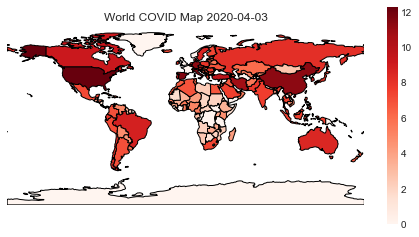

In [563]:
infect_plot("2020-02-01")
infect_plot("2020-03-01")
infect_plot("2020-04-03")